In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [245]:
def aggregated_score_function (score_matrix_per_partner,score_matrix_collective_models, agg_function,
                               init_comp_rounds_skipped, final_comp_rounds_skipped):
    
    # function that takes:
    # as input the 2 scoring matrices at the end of the simulation, an aggregation function
    # the proportion of initial and final computation rounds to be skipped
    # as output the array of contributivity score and normalized contributivity score per partner
    
    (epoch_count,minibatch_count,partners_count) = score_matrix_per_partner.shape
    
    # Calculate absolute and relative deltas of performance between partner and collective model for each round
    score_matrix_collective_models = score_matrix_collective_models[:,1:]
    score_matrix_performance_abs = np.nan * np.zeros(shape=(epoch_count, minibatch_count, partners_count))
    score_matrix_performance_rel = np.nan * np.zeros(shape=(epoch_count, minibatch_count, partners_count))
    
    for i in range (partners_count):
        score_matrix_performance_abs [:,:,i] = score_matrix_per_partner[:,:,i] - score_matrix_collective_models
        score_matrix_performance_rel [:,:,i] = np.divide(score_matrix_performance_abs[:,:,i], score_matrix_collective_models)
    
    
    #Initialize contributivity score arrays
    
    contributivity_scores = np.zeros (partners_count)
    normalized_contributivity_scores = np.zeros (partners_count)
    
    
    # reshape score matrices performance
    scores_array_abs = np.reshape(score_matrix_performance_abs,(epoch_count * minibatch_count,partners_count ))
    scores_array_rel = np.reshape(score_matrix_performance_rel,(epoch_count * minibatch_count,partners_count ))
    
    
    # skip first and last computation rounds
    first_comp_round_kept = int(np.round(epoch_count * minibatch_count * init_comp_rounds_skipped))
    last_comp_round_kept = int(np.round (epoch_count * minibatch_count * (1-final_comp_rounds_skipped)))
    
    scores_array_abs = scores_array_abs [first_comp_round_kept: last_comp_round_kept , :]
    scores_array_rel = scores_array_rel [first_comp_round_kept: last_comp_round_kept , :]
    
    comp_rounds_count = scores_array_abs.shape[0]
    
    
    # calculate contributivity scores
    
    if agg_function == "Uniform incremental increase":
        
        # compute the average delta of performance between collective model and partner model 
        # for each computation round
        
        contributivity_scores = scores_array_abs.mean(axis= 0)
        
    elif agg_function == "Relative incremental increase":
        
        # compute the average relative increase of performance between collective model and partner model
        # for each computation round
        
        contributivity_scores = scores_array_rel.mean(axis= 0)
        
    elif agg_function == "Weighted average increase":
    
        # compute the relative increase of performance between collective model and partner model 
        # for each computation round and gives more weight to the last rounds, following a uniform function
        
        contributivity_scores= np.array(np.arange(comp_rounds_count)).dot(scores_array_rel)
    
    elif agg_function == "Gaussian average increase":
        
        # compute the relative increase of performance between collective model and partner model 
        # for each computation round and gives more weight to the rounds, following a normal function
        
        normal_distrib= np.random.normal(0,1,comp_rounds_count)
        arranged_normal_distrib = np.sort(normal_distrib)+np.abs(min(normal_distrib))
        contributivity_scores= arranged_normal_distrib.dot(scores_array_rel)
        
    else :
        print ("Unrecognized aggregation function")
        
    
    normalized_contributivity_scores = contributivity_scores / np.sum(contributivity_scores)
    
    return (contributivity_scores, normalized_contributivity_scores)
    

In [246]:
# plot curves of normalized contributivity scores with x function

In [247]:
def plot_init_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_function, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped):

    scores_array=np.zeros(partners_count)
    
    for i in np.arange(init_comp_rounds_skipped_min,init_comp_rounds_skipped_max,step):
        scores= aggregated_score_function(score_matrix_per_partner,
                                          score_matrix_collective_models,
                                         agg_function=agg_function,
                                          init_comp_rounds_skipped=i,
                                         final_comp_rounds_skipped = final_comp_rounds_skipped)[1]
        scores_array=np.vstack([scores_array,scores])
    
    scores_array=scores_array[1:,:]
    
    plt.plot(np.arange(init_comp_rounds_skipped_min, init_comp_rounds_skipped_max, step), scores_array);
    plt.xlabel("proportion of initial \n computation rounds skipped \n " +str(agg_function))
    plt.ylabel ("normalized contributivity scores")
    

In [248]:
def plot_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             agg_function, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max):

    scores_array=np.zeros(partners_count)
    
    
    for i in np.arange(final_comp_rounds_skipped_min,final_comp_rounds_skipped_max,step):
        
        scores= aggregated_score_function(score_matrix_per_partner,
                                          score_matrix_collective_models,
                                         agg_function=agg_function,
                                          init_comp_rounds_skipped=init_comp_rounds_skipped,
                                         final_comp_rounds_skipped = i)[1]
        scores_array=np.vstack([scores_array,scores])
    
    scores_array=scores_array[1:,:]
    
    plt.plot(np.arange(final_comp_rounds_skipped_min, final_comp_rounds_skipped_max, step), scores_array);
    plt.xlabel("proportion of final \n computation rounds skipped \n" +str(agg_function))
    plt.ylabel ("normalized contributivity scores")

In [249]:
# test on random matrices with increasing performance

In [250]:
epoch_count = 50
minibatch_count = 20
partners_count = 3

In [251]:
#score_matrix_collective_models.shape=(epoch_count, minibatch_count +1)
# definition of a dummy score_matrix_collective_models with uniform increasing performance

score_matrix_collective_models=np.array(np.linspace(0.3,0.98,epoch_count*(minibatch_count+1))).reshape(epoch_count,minibatch_count+1)

In [252]:
# score_matrix_per_partner.shape = (epoch_count, minibatch_count, partners_count)
# definition of a dummy score_matrix_per_partner with uniform increasing performance and normal noise for each partner

score_matrix_per_partner = np.nan * np.zeros(shape=(epoch_count, minibatch_count, partners_count))
for i in range (partners_count):
    score_matrix_per_partner_temp= np.array(np.linspace(0.3,0.98,epoch_count*minibatch_count)) +np.random.random(epoch_count*minibatch_count)/100
    score_matrix_per_partner_temp=score_matrix_per_partner_temp.reshape(epoch_count,minibatch_count)
    score_matrix_per_partner[:,:,i]=score_matrix_per_partner_temp

In [253]:
matrix_test = aggregated_score_function(score_matrix_per_partner,score_matrix_collective_models,
                                 "Weighted average increase",0.3,0.8)
matrix_test

/Users/jeromechambost/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in true_divide


(array([0., 0., 0.]), array([nan, nan, nan]))

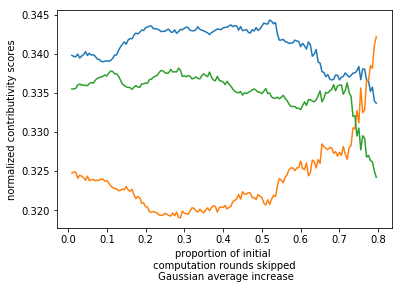

In [256]:
plot_init_rounds_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         "Gaussian average increase", 0.01,0.8,0.005,0.01)

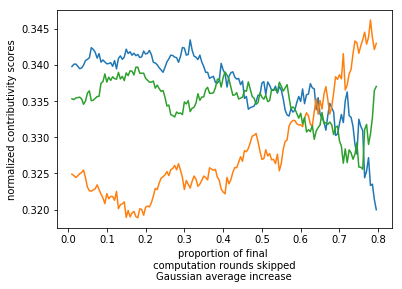

In [257]:
plot_last_rounds_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         "Gaussian average increase", 0.01,0.005,0.01,0.8)

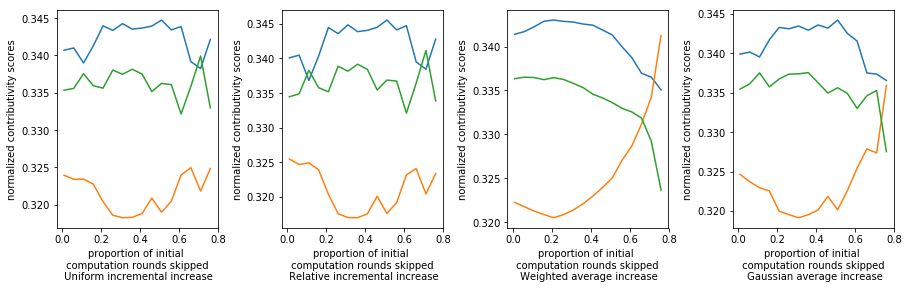

In [258]:
agg_functions= ["Uniform incremental increase","Relative incremental increase",
                "Weighted average increase","Gaussian average increase"]

init_comp_rounds_skipped_min = 0.01
init_comp_rounds_skipped_max = 0.8
step = 0.05
final_comp_rounds_skipped = 0.01

fig=plt.figure(figsize=(15,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,func in enumerate(agg_functions):
    plt.subplot(1,4,i+1)
    plot_init_rounds_skipped(score_matrix_per_partner,score_matrix_collective_models,
                         func, init_comp_rounds_skipped_min, init_comp_rounds_skipped_max,
                             step, final_comp_rounds_skipped)

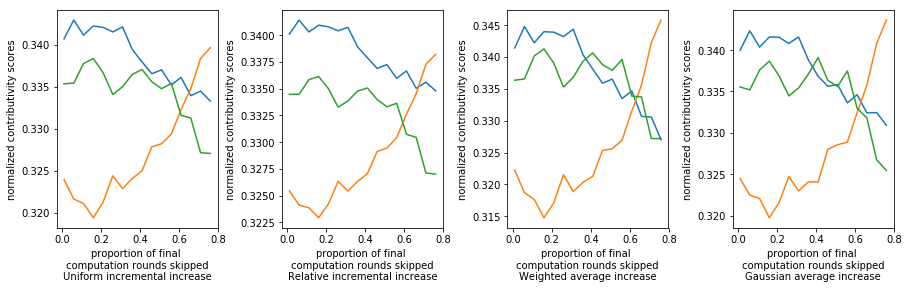

In [261]:
agg_functions= ["Uniform incremental increase","Relative incremental increase",
                "Weighted average increase","Gaussian average increase"]

init_comp_rounds_skipped = 0.01
step = 0.05
final_comp_rounds_skipped_min = 0.01
final_comp_rounds_skipped_max = 0.8

fig=plt.figure(figsize=(15,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i,func in enumerate(agg_functions):
    plt.subplot(1,4,i+1)
    plot_last_rounds_skipped(score_matrix_per_partner, score_matrix_collective_models, 
                             func, init_comp_rounds_skipped,
                             step, final_comp_rounds_skipped_min, final_comp_rounds_skipped_max)

In [ ]:
# test on real simulations : ongoing